In [1]:
# Nan in the data should be removed
import numpy as np
#from mayavi import mlab
import matplotlib.pyplot as plt
#from tvtk.api import tvtk
import matplotlib as mpl
mpl.style.use('classic')
from latexify import latexify
#%gui qt

In [5]:
# Ｄａｔａ　ｌｏａｄｉｎｇ：　ｓｐｉｎ　ｆｌｉｐ　ａｎｄ　ｓｐｉｎ　ｎｏｎｆｌｉｐ

# spin flip
datpath=r'D:\5_Neutron Scattering\4_DNS_FRM2_Jan2015\SF-Bulk10-LowT510s-1.7HighT300s0-0.txt'#delimenter is \t
datpath=r'D:\5_Neutron Scattering\4_DNS_FRM2_Jan2015\SFlowT-SFhighT.out0-0.out'#delimenter is ''

# spin non flip
#datpath=r'D:\5_Neutron Scattering\4_DNS_FRM2_Jan2015\SNFlowT-SFhighT.out0-0.out'#delimenter is ''
data0 = np.genfromtxt(datpath, dtype=float, skip_header=30,
                         delimiter=' ',usecols=(7,8,9,10))# I, error, x[110], y[001]
#print(data0)
data=data0[~np.isnan(data0)]# Nan in the data should be removed
data=data.reshape(data.shape[0]//4,4)
#print(data)
#data.tofile('D:/5_Neutron Scattering/6_E2_April_2015/output.txt', sep = ' ')

## Use matplotlib: 1. triangle (masked), 2. masked interpolated grid 

In [8]:
#　Ｍｏｄｉｆｉｅｄ　ｔｒｉａｎｇｌｅｓ　ｕｓｉｎｇ　ａｌｐｈａ＿ｓｈａｐｅ　ｆｕｃｎｔｉｏｎ
%matplotlib notebook
%matplotlib inline
x, y, z= data[:,2], data[:,3], data[:,0]+6
# Got the necessary triangles
triangles = alpha_shape2(data[:,2:],alpha=3)

plt.figure()
plt.gca().set_aspect(0.5)# 'equal'
#plt.triplot(x, y, triangles, 'go-', lw=1.0)# only plot the triangles

import matplotlib.cm as cm
cmap = cm.get_cmap(name='jet')#, lut=None)#terrain
plt.tricontourf(x, y, triangles, z, levels=[1,2,3,4,5,6,7,8,9,10], cmap=cmap)

plt.axis([-4.1,1.7, -5, 6])
plt.xlabel('[HH0]',size=14)
plt.ylabel('[00K]',size=14)
plt.minorticks_on()
plt.xticks( color='k', size=14)
plt.yticks( color='k', size=14)

# set colorbar and its properties
cb = plt.colorbar() # label='Intensity', ticks=range(0,100)
cb.ax.set_ylabel('Intensity (a.u.)',fontsize=14)
cb.ax.tick_params(labelsize=12)
#plt.title('Contour plot of Delaunay triangulation')
#plt.savefig(datpath.replace('txt','pdf'), bbox_inches="tight",verbose=True)  

plt.show()

NameError: name 'alpha_shape2' is not defined

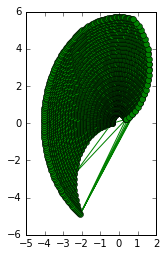

In [9]:
# Ｕｓｅ　Ｍａｔｐｌｏｔｌｉｂ　ｏｗｎ　ｔｒｉａｎｇｌｅｓ
import matplotlib.tri as tri
import time

start = time.clock()
x, y, z= data[:,2], data[:,3], data[:,0]

triang = tri.Triangulation(x, y)
#print triang.neighbors
# Mask off unwanted triangles. # radius around the zero center!!!!
min_radius = 1 
max_radius = 1.5
xmid = x[triang.triangles].mean(axis=1)
ymid = y[triang.triangles].mean(axis=1)
mask = np.where( ((xmid**2 + ymid**2 > max_radius**2) | (xmid**2 + ymid**2 < min_radius**2)), 1, 0)

triang.set_mask(mask)

plt.figure()
plt.gca().set_aspect('equal')
plt.triplot(triang, 'go-', lw=1.0)# only plot the triangles
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The griddata function was deprecated in Matplotlib 2.2 and will be removed in 3.1. Use scipy.interpolate.griddata instead.


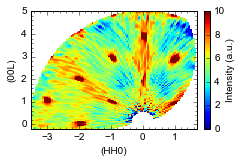

In [20]:
# use matplotlib 在grid的上内插值
shift = 8 # 8 for snf, 6 for sf channel
vmax = 10 # 10 for snf, 8 for sf
x, y, z= data[:,2], data[:,3], data[:,0]+shift
# find the envenlope of the data
hull, edge = alpha_shape1(data[:,2:],alpha=5)
hullxy = np.array(list(hull.exterior.coords))#print list(hull.exterior.coords)

# see the envenlope
# plt.figure()
# xy = np.array(list(hull.exterior.coords))
# plt.scatter(xy[:,0],xy[:,1])
# plt.show()

# have grid
ngridx = 150
ngridy = 300
xi = np.linspace(-5, 2, ngridx)
yi = np.linspace(-6, 7, ngridy)
xx, yy = np.meshgrid(xi,yi)

import matplotlib.mlab as mlab
zi = mlab.griddata(x, y, z, xi, yi, interp='linear')# zi is a grid

# mask out the pints in the grid outside the evenlope
import matplotlib.path as mplPath
bbPath = mplPath.Path(hullxy)
xylist = np.vstack(  [xx.reshape((-1,1))[:,0],  yy.reshape((-1,1))[:,0]]  ).T
mask = bbPath.contains_points(xylist).reshape(xx.shape) # or contains_points      
#print mask
zm = np.ma.masked_where(~mask, zi)

# mask outer ring
rad = np.sqrt(2*xx**2 + yy**2)
zm[rad>5.] = np.nan
zm = np.ma.masked_where(np.isnan(zm),zm)# mask Nan values then plot in white color


latexify(columns=1)
params = {'legend.fontsize': 10,
         'axes.labelsize': 10,
         'xtick.labelsize':10,
         'ytick.labelsize':10 }
mpl.rcParams.update(params)

fig = plt.figure()
plt.gca().set_aspect(0.707)

# plot contours
#plt.contour(xi, yi, zm, levels=[1,2,3,4,5,6,7,8,9,10], linewidths=0.5, colors='k')
# plt.contourf(xi, yi, zm, levels=[1,2,3,4,5,6,7,8,9,10],cmap='jet',
#              norm=plt.Normalize(vmax=abs(zi).max(), vmin=-abs(zi).max()))

# pcolor plot
#plt.pcolor(xi, yi, zm)
pcol = plt.pcolormesh(xi, yi, zm, vmin=0, vmax=vmax, cmap='jet',linewidth=0,rasterized=True)# '_r' is reversed colormap
pcol.set_edgecolor('face') # remove the white lines in the plot

#plt.scatter([-3,-2,-2,-0.9,-0.9,0.1,1], [1.1,0,2,0.9,2.95,3.9,2.9], s=150, facecolors='white', edgecolors='none')

#plt.grid()
plt.axis([-3.5, 1.7,-0.2, 5])
plt.xlabel('(HH0)')
plt.ylabel('(00L)')
plt.minorticks_on()
plt.xticks(color='k')
plt.yticks(color='k')

# set colorbar and its properties
cb = plt.colorbar(pcol,fraction=0.033, pad=0.04) # label='Intensity', ticks=range(0,100) # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
cb.ax.set_ylabel('Intensity (a.u.)',labelpad=0)
cb.ax.locator_params(tight=True, nbins=5)
#cb.ax.tick_params(labelsize=12)
#plt.title('Pcolormesh grid data')

#plt.tight_layout(w_pad=0, h_pad=0)
plt.savefig(datpath.replace('.out','_ppt.pdf'), bbox_inches="tight",pad_inches=0,verbose=True)  
plt.show()

In [18]:
datpath=r'D:\5_Neutron Scattering\4_DNS_FRM2_Jan2015\SF-Bulk10-LowT510s-1.7HighT300s0-0.txt'
data0 = np.genfromtxt(datpath, dtype=float, skip_header=30,
                         delimiter="\t",usecols=(7,8,9,10))# I, error, x[110], y[001]
#print(data0)
data=data0[~np.isnan(data0)]# Nan in the data should be removed
data=data.reshape(data.shape[0]/4,4)


## Use Mayavi

In [21]:
####Plot multi surface of a sphear
#zeroc=np.zeros((data.shape[0]))
#datap=data[:,2:]
#points =np.concatenate((datap,zeroc.T),axis=1)
#points =np.vstack((datap,zeroc))

#add one zero col to make 3D for making grid
points=np.zeros((data.shape[0],2+1))
points[:,:-1] = data[:,2:]

ug = tvtk.UnstructuredGrid(points=points)
ug.point_data.scalars = data[:,0]
ug.point_data.scalars.name = "value"

ds = mlab.pipeline.add_dataset(ug)

delaunay = mlab.pipeline.delaunay2d(ds)
iso = mlab.pipeline.iso_surface(delaunay)
iso.actor.property.opacity = 1
iso.contour.number_of_contours = 10
#edges = mlab.pipeline.extract_edges(delaunay) # try to remove but failed
#edges = mlab.pipeline.extract_edges(iso)
#mlab.pipeline.iso_surface(edges, color=(1, 1, 1))

mlab.outline()
#mlab.axes() # cause exception
mlab.show()

In [4]:
#####Try mask some data (not work): see the example below
#x, y = np.meshgrid(data[:,2],data[:,3], indexing='ij')
x = np.zeros((np.shape(data)[0],np.shape(data)[0]))
y = np.zeros_like(x)
z = np.zeros_like(x)
zzero = np.zeros_like(x)
x[:,0], y[:,0], z[:,0]=data[:,2],data[:,3],data[:,0]
#print(x,y,z)
#mask_reg=np.ones_like(z).astype(bool)
#mask_reg[:,0]=False
# mlab.mesh(x, y, zzero, scalars=z)
#print(np.shape(mask_reg))

In [6]:
#Example: try mesh to mask some region,
phi, theta = np.mgrid[0:np.pi:10j, 0:2 * np.pi:10j]
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

mask = np.zeros_like(x).astype(bool)
mask[::5] = True
mask[:,::5] = True
#print mask
mlab.mesh(x, y, z, scalars=z, mask=mask)
mlab.show()

In [8]:
#not right: splitting into layer of equal intensity
points = data[:,[2,3,0]]
ug = tvtk.UnstructuredGrid(points=points)
ug.point_data.scalars = data[:,0]
ug.point_data.scalars.name = "scalars"

ds = mlab.pipeline.add_dataset(ug)
delaunay = mlab.pipeline.delaunay2d(ds)
iso = mlab.pipeline.iso_surface(delaunay)
iso.actor.property.opacity = 0.5
iso.contour.number_of_contours = 5
mlab.show()

In [ ]:
#this is 3D plot with z as the hgitht and scalar
pts = mlab.points3d(data[:,2],data[:,3],data[:,0]+100, data[:,0]+100, colormap='jet')
# Triangulate based on X, Y with Delaunay 2D algorithm.
# Save resulting triangulation.
mesh = mlab.pipeline.delaunay2d(pts)
# Remove the point representation from the plot
pts.remove()
# Draw a surface based on the triangulation
surf = mlab.pipeline.surface(mesh, colormap='jet')

# Simple plot.
mlab.outline(extent=(0,1,0,1,0,1))
#mlab.axes(extent=(0,1,0,1,0,1))
mlab.show()

In [100]:
#Example 1 without our data plot following

X2 = np.array([0, 0, 1, 1])
Y2 = np.array([0.5, 0.45, 1, 0.5])
Z2 = np.array([0, 1, 0.5,0])

fig = mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0.5, 0.5, 0.5))
# Define the points in 3D space
# including color code based on Z coordinate.
pts = mlab.points3d(X2, Y2, Z2, Y2, colormap='jet')
# Triangulate based on X, Y with Delaunay 2D algorithm.
# Save resulting triangulation.
mesh = mlab.pipeline.delaunay2d(pts)
# Remove the point representation from the plot
pts.remove()
# Draw a surface based on the triangulation
surf = mlab.pipeline.surface(mesh, colormap='jet')

# Simple plot.
mlab.outline(extent=(0,1,0,1,0,1))
#mlab.axes(extent=(0,1,0,1,0,1))
mlab.show()

In [11]:
#this is 3D plot with z as the hgitht and scalar
from scipy.spatial import Delaunay # use scipy for delaunay:
d2d = Delaunay(data[:,2:])

fig = mlab.figure(1, bgcolor=(1, 0.7, 1), fgcolor=(0.5, 0.5, 0.5))
# Generate triangular Mesh:
tmesh = mlab.triangular_mesh(data[:,2],data[:,3],data[:,0],
                             d2d.vertices,
                             scalars=data[:,0], colormap='jet')
# Simple plot.
mlab.outline()
#mlab.axes()
mlab.show()

## Try the Triangle Module

In [8]:
# Ｔｒｙ　ｔｈｅ　Ｔｒｉａｎｇｌｅ　Ｍｏｄｕｌｅ 1
import triangle
import triangle.plot as plot

#delaunay:
d2d = triangle.triangulate(dict(vertices=data[:,2:]),'a0.8') #must use dic as input
print d2d
zzero=np.zeros_like(data[:,0]) # the hight is zero so 3D becomes 2D

fig = mlab.figure(1, bgcolor=(0,0,0), fgcolor=(0.5, 0.5, 0.5))
# Generate triangular Mesh:
tmesh = mlab.triangular_mesh(data[:,2],data[:,3],zzero,d2d['triangles'],scalars=data[:,0],scale_factor=0, colormap='jet')
#mlab.axes()
mlab.show()

{'vertex_markers': array([[0],
       [0],
       [0],
       ..., 
       [1],
       [1],
       [1]]), 'vertices': array([[-0.3965547 , -0.01475342],
       [-0.5926446 , -0.05887937],
       [-0.7852815 , -0.1271186 ],
       ..., 
       [ 1.058091  ,  5.242656  ],
       [ 0.9201773 ,  5.445561  ],
       [ 0.7703417 ,  5.630617  ]]), 'triangles': array([[ 718,  742,  791],
       [ 767,  718,  791],
       [ 839,  815,  766],
       ..., 
       [2841, 2914, 2890],
       [3150, 3126, 3029],
       [ 749,  700,  724]])}


In [33]:
# Ｔｒｙ　ｔｈｅ　Ｔｒｉａｎｇｌｅ　Ｍｏｄｕｌｅ 2
import triangle
import triangle.plot as plot
face = triangle.get_data('face') # face is a object contiaing vertex, segments
print(face)
# face['segment_markers']=[]
# face['segments']=[]
# face['vertex_markers']=[]
#print(face)
ax1 = plt.subplot(121, aspect='equal')
plot.plot(ax1, **face)

t = triangle.triangulate(face, 'p')
ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
triangle.plot.plot(ax2, **t)

plt.show()

{'segment_markers': array([[2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [3],
       [3],
       [3],
       [3],
       [4],
       [4],
       [4],
       [4],
       [5],
       [5],
       [5],
       [5],
       [6],
       [6]]), 'segments': array([[ 0,  1],
       [ 1,  2],
       [ 2,  3],
       [ 3,  4],
       [ 4,  5],
       [ 5,  6],
       [ 6,  7],
       [ 7,  0],
       [ 8,  9],
       [ 9, 10],
       [10, 11],
       [11,  8],
       [12, 13],
       [13, 14],
       [14, 15],
       [15, 12],
       [16, 17],
       [17, 18],
       [18, 19],
       [19, 16],
       [20, 21],
       [22, 23]]), 'vertex_markers': array([[2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [3],
       [3],
       [3],
       [3],
       [4],
       [4],
       [4],
       [4],
       [5],
       [5],
       [5],
       [5],
       [6],
       [6],
       [7],
       [7],
       [0],
       [

In [72]:
#our data
import triangle
import triangle.plot as plot

# dots = triangle.get_data('dots')
# pts = dots['vertices']
pts = data[:,2:]
segs = triangle.convex_hull(pts) # make hull (boundary)
#print segs
t = triangle.triangulate(dict(vertices=data[:,2:],segments=np.array(segs),holes=np.array([[0,0.25],[-1.5,-2]])),
                         'q0.1S0Xa0.01')
#print t
t = triangle.triangulate(t, '-r box.1')
#print t
#print pts, segs
ax1 = plt.subplot(111, aspect='equal')
#plot.plot(ax1, vertices=pts, segments=segs)
plot.plot(ax1, **t)
plt.show()

In [58]:

spiral = triangle.get_data('spiral')
#print spiral
ax1 = plt.subplot(121, aspect='equal')
plot.plot(ax1, **spiral)

t = triangle.triangulate(spiral)

ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
plot.plot(ax2, **t)

plt.show()

In [ ]:
import triangle
import triangle.plot as plot
import matplotlib.pyplot as plt

dots = triangle.get_data('dots')
pts = dots['vertices']
segs = triangle.convex_hull(pts)

plot.plot(plt.axes(), vertices=pts, segments=segs)

plt.show()

(300L, 300L)


In [80]:
####One example
%gui qt
import numpy as np
from tvtk.api import tvtk
from mayavi import mlab
z = np.linspace(0 , 100 , 11)
x , y , z = np.mgrid [0:360:37j ,-89:89:37j , 0:100:11j ]
t = 288.15 - 6.5*z
mlab.contour3d ( x , y , z , t )
mlab.outline()
mlab.colorbar()

In [81]:
#same result as above
P = mlab.pipeline
src = P.scalar_field(x , y , z , t )
iso = P.iso_surface (src)
mlab.outline()
mlab.colorbar()
# Try t h i s .
#print src

In [19]:
orig = (0 , -90, 0)
spacing = (10 , 5 , 10)
dims = (37 , 37 , 11)
id = tvtk.ImageData ( origin =orig,spacing=spacing ,dimensions=dims )
id.point_data.scalars = t.T.flatten( )
id.point_data.scalars.name ="T"
# View i t .
src = P.add_dataset ( id )
iso = P.iso_surface ( src )

## The function for masking triangles, finding evenlopes

In [11]:
# the original one
#http://blog.thehumangeo.com/2014/05/12/drawing-boundaries-in-python/
import shapely.geometry as geometry
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])
            
    coords = np.array([point.coords[0] for point in points])
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points

In [13]:
# the modified one: http://blog.thehumangeo.com/2014/05/12/drawing-boundaries-in-python/
# Ｆｉｎｄ　ｔｈｅ　ｅｖｅｎｌｏｐｅｓ　
import shapely.geometry as geometry
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math
def alpha_shape1(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])
            
    coords = np.array([point for point in points])
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m)) # triangles is just the envenlope?!!!
    return cascaded_union(triangles), edge_points

In [14]:
# The modified：　http://blog.thehumangeo.com/2014/05/12/drawing-boundaries-in-python/
# Ｇｅｎｅｒａｔｉｎｇ　ｔｒａｎｇｌｅｓ　ｗｉｔｈ　ａｊｕｓｔａｂｌｅ　ｈｕｌｌ　（ｃｈａｎｇｅ　ａｌｐｈａ）

from scipy.spatial import Delaunay
import numpy as np
import math
def alpha_shape2(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers. Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return Delaunay(points)
       
    tri = Delaunay(points)
    new_tri = []
    edges = set()
    edge_points = []
    # loop over triangles: ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            new_tri.append([ia, ib, ic])    
    return new_tri

In [120]:
from descartes.patch import PolygonPatch

ImportError: No module named descartes.patch